In [0]:
import os
import shutil
import zipfile
import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.preprocessing import image
import cv2

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [39]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/custom/cats_and_dogs_filtered.zip
  

local_zip = '/tmp/custom/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/custom')
zip_ref.close()

--2019-07-15 09:52:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/custom/cats_and_dogs_filtered.zip’

/tmp/custom/cats_an 100%[===================>]  65.43M  92.3MB/s    in 0.7s    

2019-07-15 09:52:54 (92.3 MB/s) - ‘/tmp/custom/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
#shutil.rmtree('/tmp/cats_and_dogs_filtered')

In [0]:
base_dir = '/tmp/custom/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')                 

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 33, 33, 128)       147584    
__________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [0]:
target_width = 300
target_height = 300

In [48]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

In [50]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=40,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2,
      callbacks=[es])

Epoch 1/40
 - 15s - loss: 0.6938 - acc: 0.5105 - val_loss: 0.6874 - val_acc: 0.5400
Epoch 2/40
 - 14s - loss: 0.6863 - acc: 0.5610 - val_loss: 0.6689 - val_acc: 0.6050
Epoch 3/40
 - 14s - loss: 0.6609 - acc: 0.5995 - val_loss: 0.6396 - val_acc: 0.6500
Epoch 4/40
 - 14s - loss: 0.6386 - acc: 0.6300 - val_loss: 0.7098 - val_acc: 0.5600
Epoch 5/40
 - 14s - loss: 0.6115 - acc: 0.6760 - val_loss: 0.6036 - val_acc: 0.6900
Epoch 6/40
 - 14s - loss: 0.5755 - acc: 0.6900 - val_loss: 0.5906 - val_acc: 0.6900
Epoch 7/40
 - 14s - loss: 0.5510 - acc: 0.7165 - val_loss: 0.6986 - val_acc: 0.6150
Epoch 8/40
 - 14s - loss: 0.5101 - acc: 0.7460 - val_loss: 0.5272 - val_acc: 0.7050
Epoch 9/40
 - 14s - loss: 0.4938 - acc: 0.7550 - val_loss: 0.5524 - val_acc: 0.7200
Epoch 10/40
 - 14s - loss: 0.4645 - acc: 0.7795 - val_loss: 0.5520 - val_acc: 0.7100
Epoch 11/40
 - 14s - loss: 0.4370 - acc: 0.7835 - val_loss: 0.6087 - val_acc: 0.6550
Epoch 12/40
 - 14s - loss: 0.3996 - acc: 0.8170 - val_loss: 0.6191 - val_a

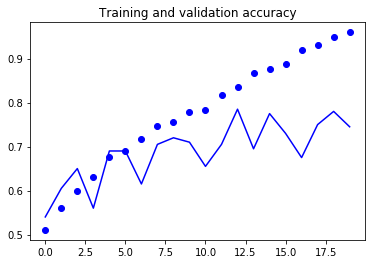

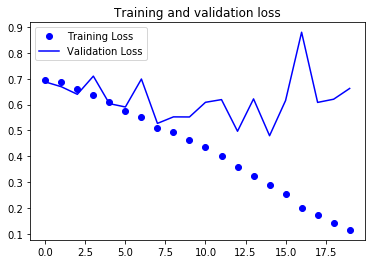

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()